
##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [0]:
# Copyright 2019 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# DDSP Synths and Effects

This notebook demonstrates the use of several of the Synths and Effects Processors in the DDSP library. While the core functions are also directly accessible through `ddsp.core`, using Processors is the preffered API for end-2-end training. 

As demonstrated in the [0_processors.ipynb](colab/tutorials/0_processors.ipynb) tutorial, Processors contain the necessary nonlinearities and preprocessing in their `get_controls()` method to convert generic neural network outputs into valid processor controls, which are then converted to signal by `get_signal()`. The two methods are called in series by `__call__()`.

While each processor is capable of a wide range of expression, we focus on simple examples here for clarity.

In [0]:
# Imports.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from colabtools import sound
import ddsp
from ddsp import core
from ddsp import effects
from ddsp import synths
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf

# Helper Functions.
sess = tf.compat.v1.InteractiveSession()
sample_rate = 16000
play = lambda x: sound.Play(x, sample_rate)
f32 = core.f32

def specplot(audio, vmin=-5, vmax=1, rotate=True, size=512 + 256):
  logmag = ddsp.spectral_ops.calc_logmag(f32(audio), size=size).eval()
  if rotate:
    logmag = np.rot90(logmag)
  plt.matshow(logmag, vmin=vmin, vmax=vmax, cmap=plt.cm.magma, aspect='auto')
  plt.xticks([])
  plt.yticks([])

# Synths

Synthesizers, located in `ddsp.synths`, take network outputs and produce a signal (usually used as audio). 

## Additive

The additive synthesizer models a sound as a linear combination of harmonic sinusoids. Amplitude envelopes are generated with 50% overlapping hann windows. The final audio is cropped to n_samples.

Inputs:
* `amplitudes`: Amplitude envelope of the synthesizer output.
* `harmonic_distribution`: Normalized amplitudes of each harmonic.
* `frequencies`: Frequency in Hz of base oscillator

In [0]:
n_frames = 1000
hop_size = 64
n_samples = n_frames * hop_size

# Amplitude [batch, n_frames, 1].
# Make amplitude linearly decay over time.
amps = np.linspace(1.0, -3.0, n_frames)
amps = amps[np.newaxis, :, np.newaxis]

# Harmonic Distribution [batch, n_frames, n_harmonics].
# Make harmonics decrease linearly with frequency.
n_harmonics = 20
harmonic_distribution = np.ones([n_frames, 1]) * np.linspace(1.0, -1.0, n_harmonics)[np.newaxis, :]
harmonic_distribution = harmonic_distribution[np.newaxis, :, :]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = 440.0 * np.ones([1, n_frames, 1])

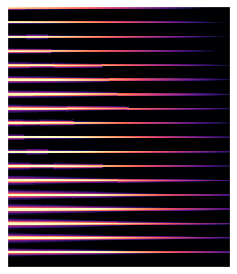

In [0]:
# Create synthesizer object.
additive_synth = synths.Additive(n_samples=n_samples,
                                 amp_scale_fn=core.exp_sigmoid,
                                 sample_rate=sample_rate)

# Generate some audio.
audio = additive_synth(f32(amps), 
                       f32(harmonic_distribution), 
                       f32(f0_hz))
audio_np = audio.eval()[0, :]

# Listen.
play(audio_np)
specplot(audio_np)

## Filtered Noise



The filtered noise synthesizer is a subtractive synthesizer that shapes white noise with a series of time-varying filter banks. 

Inputs:
* `magnitudes`: Amplitude envelope of each filter bank (linearly spaced from 0Hz to the Nyquist frequency).

In [0]:
n_frames = 250
n_frequencies = 1000
n_samples = 64000

# Bandpass filters, [n_batch, n_frames, n_frequencies].
magnitudes = [tf.sin(tf.linspace(0.0, w, n_frequencies)) for w in np.linspace(8.0, 80.0, n_frames)]
magnitudes = tf.stack(magnitudes)
magnitudes = magnitudes[tf.newaxis, :, :]

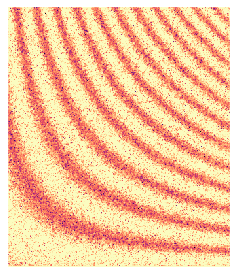

In [0]:
# Create synthesizer object.
filtered_noise_synth = synths.FilteredNoise(n_samples=n_samples,
                                            amp_scale_fn=core.exp_sigmoid)

# Generate some audio.
audio = filtered_noise_synth(magnitudes)
audio_np = audio.eval()[0, :]

# Listen.
play(audio_np)
specplot(audio_np)

## Wavetable

The wavetable synthesizer generates audio through interpolative lookup from small chunks of waveforms (wavetables) provided by the network. In priciple, very similar to the `Additve` synth, but with a parameterization in the waveform domain, and generation using linear interpolation vs. cumulative summation of sinusoid phases.

Inputs:
* `amplitudes`: Amplitude envelope of the synthesizer output.
* `wavetables`: A series of wavetables that are interpolated to cover n_samples.
* `frequencies`: Frequency in Hz of base oscillator

In [0]:
n_samples = 64000
n_wavetable = 2048
n_frames = 100

# Amplitude [batch, n_frames, 1].
amps = tf.linspace(0.5, 1e-3, n_frames)[tf.newaxis, :, tf.newaxis]

# Fundamental frequency in Hz [batch, n_frames, 1].
f0_hz = 110 * tf.linspace(1.5, 1, n_frames)[tf.newaxis, :, tf.newaxis]

# Wavetables [batch, n_frames, n_wavetable].
# Sin wave
wavetable_sin = tf.sin(tf.linspace(0.0, 2.0 * np.pi, n_wavetable))
wavetable_sin = wavetable_sin[tf.newaxis, tf.newaxis, :]

# Square wave
wavetable_square = tf.cast(wavetable_sin > 0.0, tf.float32) * 2.0 - 1.0

# Combine them and upsample to n_frames.
wavetables = tf.concat([wavetable_square, wavetable_sin], axis=1)
wavetables = core.resample(wavetables, n_frames)

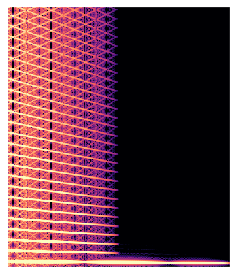

In [0]:
# Create synthesizer object.
wavetable_synth = synths.Wavetable(n_samples=n_samples,
                                   sample_rate=sample_rate,
                                   amp_scale_fn=None)

# Generate some audio.
audio = wavetable_synth(amps, wavetables, f0_hz)

# audio = wavetable_synth(magnitudes)
audio_np = audio.eval()[0, :]

# Listen.
play(audio_np)
specplot(audio_np)

# Effects

Effects, located in `ddsp.effects` are different in that they take network outputs and an audio signal, and use it to transform that signal. Some effects, such as Reverb, optionally have trainable parameters of their own.

## Reverb

## DelayModulation

## Filter